## Biomassestatistikk etter produksjonsområde

Data hentet fra [Fiskeridirektoratet](https://www.fiskeridir.no/Akvakultur/Tall-og-analyse/Biomassestatistikk/Biomassestatistikk-etter-produksjonsomraade)

### Importing data

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from helpers.dicts import traffic_light
import seaborn as sns
import matplotlib.dates as mdates
import scipy as sp
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
with open("input/biomasse.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data["Data"])

### Cleaning data

* Standardization: Round "BIOMASSE_KG" to integer
* Merge: "TRAFFIC_LIGHTS" based on helpers/dicts.py
* Sum "UTSETTSÅR"
* Remove 2024

In [3]:
df["BIOMASSE_KG"] = df["BIOMASSE_KG"].round().astype(int)
df["TRAFFIC_LIGHT"] = df["PO_KODE"].map(lambda x: traffic_light.get(x, {}).get("light"))
df["DATO"] = pd.to_datetime(df["ÅR"].astype(str) + "-" + df["MÅNED_KODE"].astype(str))
clean_df = df.groupby(["DATO", "PO_KODE", "PO_NAVN", "ARTSID", "TRAFFIC_LIGHT"]).agg({"BEHFISK_STK": "sum", "BIOMASSE_KG": "sum"}).reset_index()
clean_df = clean_df[(clean_df["DATO"].dt.year != 2024) & (clean_df["DATO"].dt.year != 2017)]
clean_df = clean_df[clean_df["ARTSID"] == "LAKS"]

### Functions

In [13]:
def monthly_laks(df, color):
    laks_df = df[(df["TRAFFIC_LIGHT"] == color) & (df['ARTSID'] == "LAKS")]
    laks_df.loc[:, "DATO"] = pd.to_datetime(laks_df["DATO"])
    return laks_df

def monthly_regnbue(df, color):
    color_df = df[df["TRAFFIC_LIGHT"] == color]
    orret_df = color_df[color_df['ARTSID'] == "REGNBUEØRRET"]
    orret_df.loc[:, "DATO"] = pd.to_datetime(orret_df["DATO"])
    return orret_df

def pval(data):
    pval_rows = []
    for name in data["PO_NAVN"].unique():
        data_temp = data.query("PO_NAVN==@name")
        r, p = sp.stats.pearsonr(data_temp["DATO"], data_temp["BIOMASSE_KG"])
        pval_rows.append({'name': name, 'pvalue': p, 'slope': r})
    df_pvalue = pd.DataFrame(pval_rows)
    return df_pvalue

### Processing data

<Axes: ylabel='Frequency'>

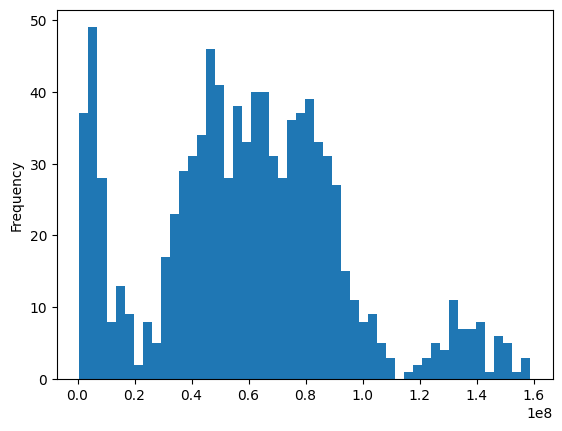

In [44]:
clean_df["BIOMASSE_KG"].plot.hist(bins=50)

In [36]:
green = monthly_laks(clean_df, "green")["BIOMASSE_KG"].describe().round().astype(int)
yellow = monthly_laks(clean_df, "yellow")["BIOMASSE_KG"].describe().round().astype(int)
red = monthly_laks(clean_df, "red")["BIOMASSE_KG"].describe().round().astype(int)

describe = pd.concat([green, yellow, red], axis=1, join="inner")
describe.columns = ["Green", "Yellow", "Red"]
describe

,Green,Yellow,Red
count,576,216,144
mean,60949458,46667573,75403883
std,40257287,12758139,18284584
min,681183,21543098,42291723
25%,28627614,37406773,58810551
50%,65684241,45513546,75650562
75%,83202614,55720590,90896734
max,158886917,79616926,110028531


In [42]:
green = monthly_laks(clean_df, "green")
yellow = monthly_laks(clean_df, "yellow")
red = monthly_laks(clean_df, "red")
colors = pd.concat([green["BIOMASSE_KG"], yellow["BIOMASSE_KG"], red["BIOMASSE_KG"]], axis=1, join="inner")
colors.columns = ["Green", "Yellow", "Red"]
colors
# ax = green.boxplot(column="BIOMASSE_KG")
# ax.set_title('Boxplot for Green, Yellow, and Red')
# ax.set_ylabel('Values')
# plt.show()

,Green,Yellow,Red


/var/folders/_x/sb88pn2x5n155w8cdkqc519m0000gp/T/ipykernel_3998/2318364905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laks_df["DATO"] = pd.to_datetime(laks_df["DATO"])


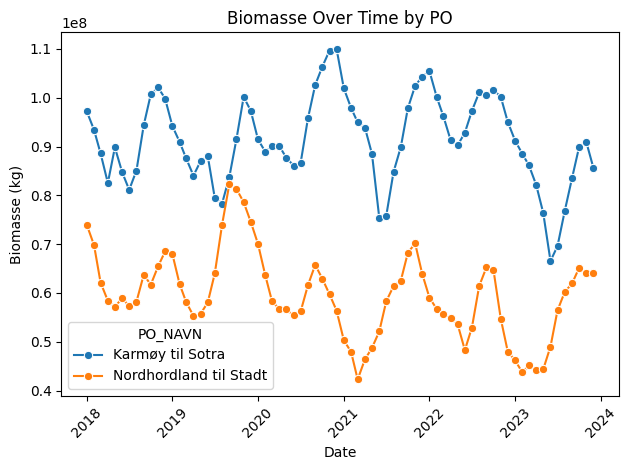

In [10]:
laks_line = monthly_laks(clean_df, "red")
lineplot = sns.lineplot(data=laks_line, x='DATO', y='BIOMASSE_KG', hue='PO_NAVN', marker='o')

plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.title('Biomasse Over Time by PO')
plt.xlabel('Date')
plt.ylabel('Biomasse (kg)')
plt.legend(title='PO_NAVN')
plt.tight_layout()
plt.show()

## GRØNNE OMRÅDER

/var/folders/_x/sb88pn2x5n155w8cdkqc519m0000gp/T/ipykernel_3998/2318364905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laks_df["DATO"] = pd.to_datetime(laks_df["DATO"])
/var/folders/_x/sb88pn2x5n155w8cdkqc519m0000gp/T/ipykernel_3998/4113816176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laks_green['DATO'] = mdates.date2num(laks_green['DATO'])


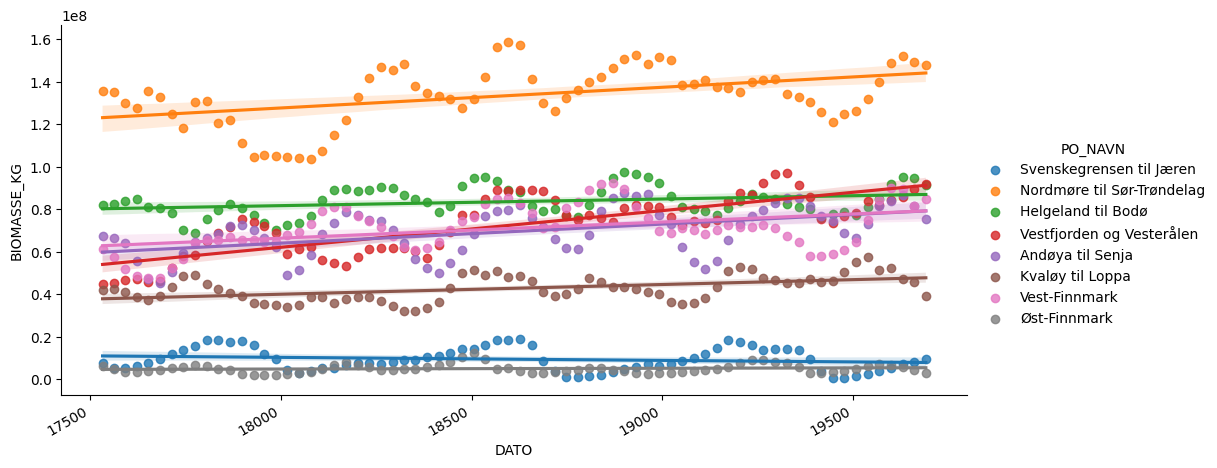

In [5]:
laks_green = monthly_laks(clean_df, "green")
laks_green['DATO'] = mdates.date2num(laks_green['DATO'])
laks = sns.lmplot(data=laks_green, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
plt.gcf().autofmt_xdate()
plt.show()

## GULE OMRÅDER

/var/folders/_x/sb88pn2x5n155w8cdkqc519m0000gp/T/ipykernel_3998/2318364905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laks_df["DATO"] = pd.to_datetime(laks_df["DATO"])
/var/folders/_x/sb88pn2x5n155w8cdkqc519m0000gp/T/ipykernel_3998/1147202183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laks_yellow['DATO'] = mdates.date2num(laks_yellow['DATO'])


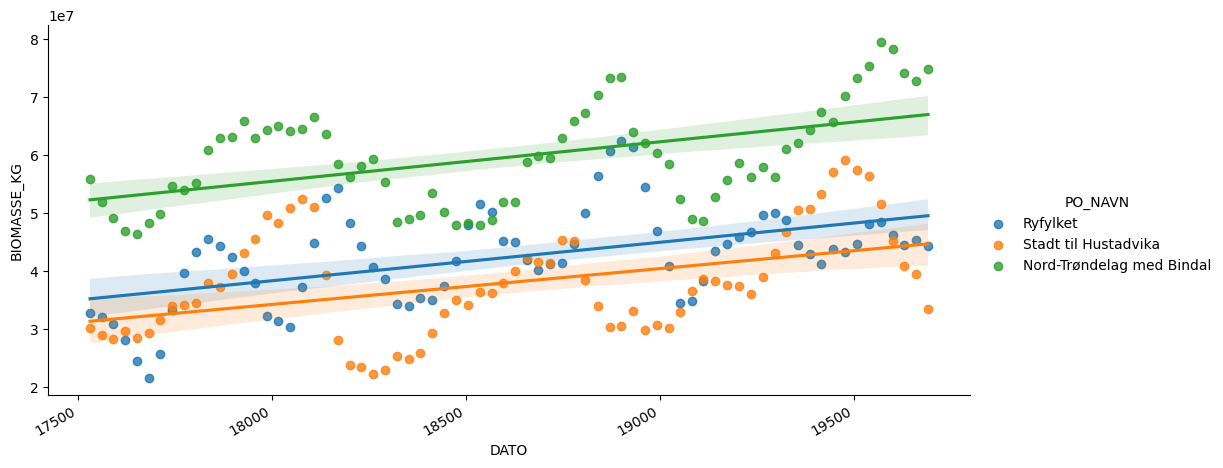

In [6]:
laks_yellow = monthly_laks(clean_df, "yellow")
laks_yellow['DATO'] = mdates.date2num(laks_yellow['DATO'])
    
pval(laks_yellow)
laks = sns.lmplot(data=laks_yellow, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
plt.gcf().autofmt_xdate()
plt.show()

## RØDE OMRÅDER

/var/folders/_x/sb88pn2x5n155w8cdkqc519m0000gp/T/ipykernel_3998/2318364905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laks_df["DATO"] = pd.to_datetime(laks_df["DATO"])
/var/folders/_x/sb88pn2x5n155w8cdkqc519m0000gp/T/ipykernel_3998/453169889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laks_red['DATO'] = mdates.date2num(laks_red['DATO'])


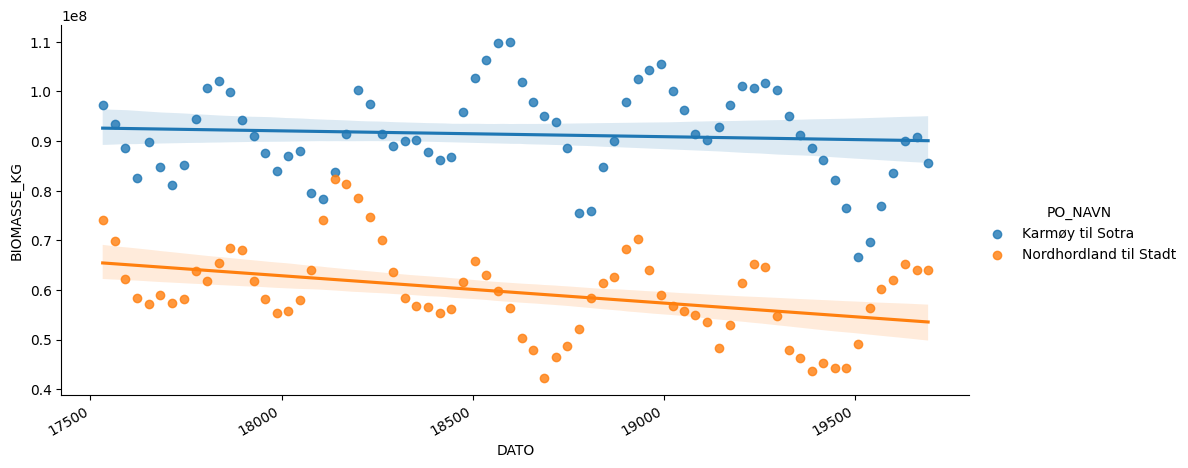

In [7]:
laks_red = monthly_laks(clean_df, "red")
laks_red['DATO'] = mdates.date2num(laks_red['DATO'])
pval(laks_red)
laks = sns.lmplot(data=laks_red, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
plt.gcf().autofmt_xdate()
plt.show()

In [8]:
df_pvalue = pval(laks_red)
df_pvalue

,name,pvalue,slope
0,Karmøy til Sotra,0.491110,-0.082450
1,Nordhordland til Stadt,0.000518,-0.398939
